# Evaluating the Color Classifier

In `02_training.ipynb`, we trained a transfer-learned ResNet18 and saved the model weights corresponding to the best validation accuracy. In this notebook, we load that best checkpoint and evaluate it on the held-out test split. Because our “ground truth” labels are produced by a heuristic rather than manual annotation, test-set metrics should be interpreted as how well the model reproduces the heuristic labeling rule on unseen images, and where it disagrees.

We begin with quantitative metrics—loss, accuracy, confusion matrix, and per-class precision/recall/F1-scores to assess overall performance and class-level behavior. These are followed by a qualitative inspection of high-confidence misclassifications. Together, these approaches provide a more complete picture of model behavior under noisy supervision and help distinguish genuine modeling errors from ambiguity or disagreement in the heuristic labeling process.

The goal of this evaluation is not merely to maximize a single metric, but to understand whether the model has learned a meaningful and biologically plausible representation of flower color.

## Recreate Simple Labeling Heuristic from `01_exploration.ipynb`

The next three cells redefine the helper functions (`hue_collector`, `classify_pixel_color`, and `hue_to_color`) so that this notebook can run independently without relying on variables defined earlier.

In [1]:
def hue_collector(img_tensor, center_frac=0.5, stride=6):
    """
    Extract RGB pixel samples from the center region of an image using a fixed stride.

    The goal is to gather a representative set of flower-petal pixels (where the flower
    is usually located) without processing the full image.

    Args:
        img_tensor (torch.Tensor):
            Image tensor of shape [3, H, W], with values in [0, 1].
        center_frac (float):
            Fraction of the image height/width to keep as the center crop.
            For example, 0.5 keeps the central 50% area.
        stride (int):
            Take every Nth pixel in both height and width to reduce sample count.

    Returns:
        pixels (np.ndarray):
            Array of shape [N, 3], containing sampled RGB pixels in [0, 1].
    """

    # Convert PyTorch tensor (C, H, W) -> NumPy array (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy()
    H, W, _ = img.shape

    # Compute center crop bounds
    crop_h = int(H * center_frac)
    crop_w = int(W * center_frac)
    h0 = (H - crop_h) // 2
    h1 = h0 + crop_h
    w0 = (W - crop_w) // 2
    w1 = w0 + crop_w

    center_region = img[h0:h1, w0:w1, :]  # shape: [crop_h, crop_w, 3]

    # Sample every `stride` pixels for reproducibility and speed
    sampled = center_region[::stride, ::stride, :]  # shape approx: [crop_h/stride, crop_w/stride, 3]

    # Flatten to shape [N, 3]
    pixels = sampled.reshape(-1, 3)
    return pixels

In [2]:
import colorsys

def classify_pixel_color(r, g, b):
    """
    Classify a single pixel into a coarse color category using HSV thresholds.

    Args:
        r, g, b (float): Red, Green, Blue channel values in [0, 1].

    Returns:
        str: One of:
            "white", "red_pink", "orange", "yellow", "green", "purple_blue", or "none".
    """

    # Convert from RGB (0–1) to HSV:
    # h in [0,1) -> hue as a fraction of the color wheel
    # s in [0,1] -> saturation (color intensity)
    # v in [0,1] -> value/brightness
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    deg = h * 360 # easier to reason about degrees than fractions

    # Heuristic for "white": low saturation but still fairly bright.
    # (These thresholds are intentionally loose; we only need coarse labels.)
    if s < 0.2 and v > 0.7:
        return "white"

    # Hue-based color classification (degrees around the color wheel).
    # Red wraps around 0 degrees, so we combine low and high hue values.
    if deg < 5 or deg >= 300:
        return "red_pink"
    if 5 <= deg < 32:
        return "orange"
    if 32 <= deg < 75:
        return "yellow"
    if 75 <= deg < 165:
        return "green"
    if 165 <= deg < 300:
        return "purple_blue"

    # Fallback for any pixel that doesn't fit the thresholds above.
    return "none"

In [3]:
from collections import Counter

def hue_to_color(pixels, sig_threshold=0.20):
    """
    Assign a single coarse color label to an image, based on the majority color
    of sampled pixels in the center region.

    Args:
        pixels (np.ndarray): Array of shape [N, 3], containing RGB values in [0, 1].
        sig_threshold (float): Minimum fraction a color class must represent
                               to be considered "significant."

    Returns:
        str: One of the coarse color classes, e.g.:
             "purple_blue", "red_pink", "white", "orange", "yellow", "green", or "none".
        bool: True if confident in label assignment, False otherwise.
    """

    # Step 1: classify each sampled pixel
    classes = []
    for r, g, b in pixels:
        cls = classify_pixel_color(r, g, b)
        if cls != "none":
            classes.append(cls)

    # If no classified pixels exist (unlikely but possible), return none.
    if not classes:
        return "none"

    # Step 2: count occurrences of each color class
    counts = Counter(classes)
    total = sum(counts.values())

    # Step 3: determine which colors exceed the significance threshold
    sig_classes = [
        cls for cls, cnt in counts.items()
        if (cnt / total) > sig_threshold
    ]

    # Step 4: If exactly one significant color exists, use it directly
    # and indicate high confidence in it.
    if len(sig_classes) == 1:
        return sig_classes[0]

    # Step 5 (priority resolution):
    # If multiple significant classes exist, choose according to a priority order
    # and indicate low confidence.
    #
    # We prioritize "white" above "orange" and "yellow" because, in practice,
    # those warm colors often come from pollen in the center of otherwise white flowers.
    # Without this rule, many white flowers would be mislabeled as yellow/orange.
    priority = ["purple_blue", "red_pink", "white", "orange", "yellow"]

    for cls in priority:
        if cls in sig_classes:
            return cls

    # Step 6: fallback for edge cases
    return "green"

## Prepare the Dataset

Here we apply our heuristic to the larger test split of *Flowers102* to generate the "ground truth" labels to which we will compare the model predictions.

In [4]:
import os
import sys
import torch
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

# Allow importing project code from ../src
sys.path.append("../src")

from models.classifier import get_resnet18
from data.dataset import ColorLabeledDataset

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Minimal transforms for creating the test split
test_tf = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# Most basic transform for labeling
label_tf = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

# Load Flowers102 test split
test_label_ds = Flowers102(root="../data", split="test", download=False, transform=label_tf)
test_ds = Flowers102(root="../data", split="test", download=False, transform=test_tf)

# Generate heuristic labels for the test split
test_color_labels = []

for i in tqdm(range(len(test_label_ds)), desc="Generating heuristic labels for testing"):
    img, _ = test_label_ds[i]
    pixels = hue_collector(img)
    label = hue_to_color(pixels)
    test_color_labels.append(label)

# Dataset
color_test_ds = ColorLabeledDataset(test_ds, test_color_labels)

Device: cuda


Generating heuristic labels for testing: 100%|█████████████████████████████████████| 6149/6149 [00:20<00:00, 294.40it/s]


# Prepare Dataloader and Model

Now we use our heuristically-labeled and unambiguous filtered dataset to prepare a DataLoader for feeding the test data to the model. The model itself will be configured using either the best set of weights from the latest epoch run, or the static best set of weights included in this repository for easy review of the original work.

In [5]:
# Dataloader
test_loader = DataLoader(
    color_test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=4
)

print("Classes:", color_test_ds.classes)
print("Test samples:", len(color_test_ds))

# Load best model checkpoint
# Choose whether to load newest generated checkpoint or stored checkpoint
ckpt_path = "../results/best_model_weights_static.pt"
#ckpt_path = "../results/best_model_weights.pt"
assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"

model = get_resnet18(len(color_test_ds.classes)).to(device)
state_dict = torch.load(
    ckpt_path,
    map_location=device,
    weights_only=True
)
model.load_state_dict(state_dict)

print("Loaded checkpoint:", ckpt_path)

Classes: ['green', 'orange', 'purple_blue', 'red_pink', 'white', 'yellow']
Test samples: 6149
Loaded checkpoint: ../results/best_model_weights_static.pt


## Overall Test Performance

We begin evaluation by computing the model’s overall accuracy and average loss on the held-out test set. Accuracy measures how often the model’s predicted label matches the heuristic label, while loss measures how well the model’s predicted probability distributions align with those labels. Together, these metrics provide a high-level summary of how well the trained model generalizes to unseen images. Because the model weights loaded here correspond to the best validation checkpoint, this evaluation reflects the model configuration that generalized best during training.

In [6]:
import torch
import numpy as np

model.eval()

# Use the same loss function as during training.
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.2)

test_losses = []
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y)

        test_losses.append(loss.item())

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

test_loss = np.mean(test_losses)
test_acc = correct / total

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 1.1564
Test accuracy: 0.7528


### Interpreting Loss

Before making a final classification, the model outputs a probability distribution over the possible color classes. The loss function compares this predicted distribution to a target distribution that represents the expected label for each image.

Without label smoothing, the target distribution would be one-hot: all probability mass assigned to a single color class. Because color labels in this project are assigned heuristically from image hue and are therefore inherently noisy and ambiguous near class boundaries, we instead train with label smoothing (label_smoothing = 0.2). This replaces the one-hot target with a softened distribution (e.g., [0.05, 0.80, 0.05, 0.05, 0.05] for a five-class problem), explicitly allowing uncertainty in the supervision signal.

Cross-entropy loss measures the negative log-likelihood of the model’s predicted probabilities under this smoothed target distribution. In a five-class setting, random guessing yields an expected loss of ln(5) ≈ 1.61. With label smoothing enabled, even a near-perfect classifier cannot achieve zero loss; the theoretical lower bound rises to approximately 0.3-0.5 depending on the sharpness of the model’s predicted probabilities.

The observed test loss of 1.1564 is substantially better than random, indicating that the model has learned meaningful color structure. However, because label smoothing penalizes confidence mismatch rather than decision correctness, this value primarily reflects calibrated uncertainty rather than outright classification failure.

### Interpreting Accuracy

Accuracy measures whether the model’s most probable predicted label matches the heuristic color label, independent of confidence. The model assigns the correct color class to approximately 75% of test images. For a five-class problem with noisy supervision, this represents strong performance, particularly given that most misclassifications occur between adjacent color categories (see Confusion Matrix below).

Taken together, accuracy and loss indicate that the model reliably captures coarse flower color categories while maintaining appropriate uncertainty in ambiguous cases.

## Confusion Matrix

To better understand which classes the model confuses with one another, we compute a confusion matrix on the test set.

Each row of the matrix corresponds to the heuristic (true) label, and each column corresponds to the model’s predicted label. Values along the diagonal represent correct predictions, while off-diagonal entries indicate systematic confusions between classes.

Because our labels are coarse color categories, the confusion matrix helps reveal:
- which colors are visually similar to the model,
- whether certain classes (e.g., white vs. yellow) are commonly confused,
- and whether class imbalance or label noise may be affecting performance.

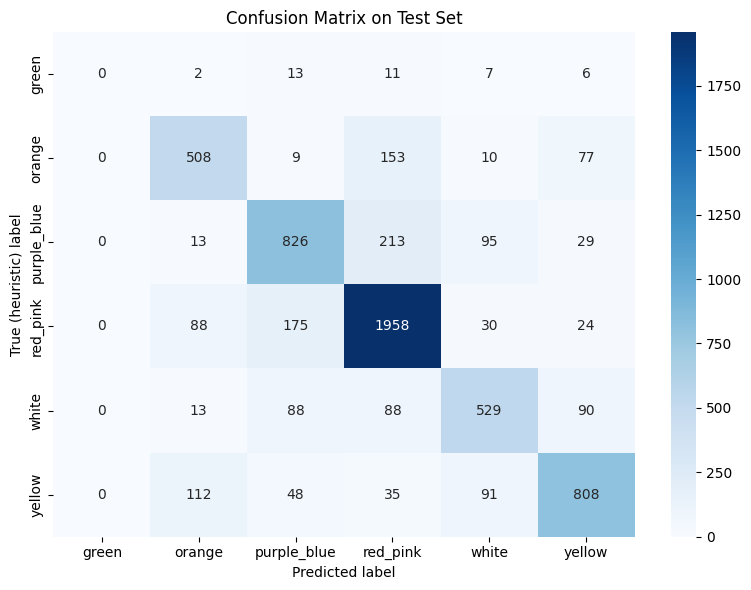

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Collect true and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class names (ensure consistent ordering)
class_names = color_test_ds.classes

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True (heuristic) label")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

### Interpreting the Confusion Matrix

The confusion matrix shows strong diagonal dominance, indicating that no color class is systematically confused with an unrelated class. In particular, there are no large off-diagonal blocks that would suggest a collapse of the model toward a single dominant label.

The most frequent misclassifications occur between adjacent colors on the color wheel: yellow is occasionally predicted as orange, orange as red_pink, and red_pink and purple_blue are frequently confused with one another. This pattern is expected given the continuous nature of flower pigmentation, where hue transitions reflect gradual shifts in underlying pigment composition rather than discrete boundaries.

Importantly, misclassifications rarely skip multiple color categories (e.g., yellow directly to purple_blue), suggesting that the model has learned a meaningful low-dimensional color structure rather than relying on spurious visual cues. Combined with an overall accuracy of approximately 75%, the confusion matrix indicates that the classifier captures coarse flower color reliably while expressing uncertainty primarily in biologically plausible edge cases.

## Precision, Recall, and F1-Score

While overall accuracy summarizes how often the model’s predictions match the heuristic color labels, it does not describe how different types of errors are distributed across classes. Precision, recall, and F1-score provide a more granular view of model performance on a per-class basis.

For a given color class:

- Precision measures how often images predicted to belong to that class are actually labeled as such. Low precision indicates that the model is over-predicting a class and frequently including false positives.

- Recall measures how often images that truly belong to a class are correctly identified by the model. Low recall indicates that the model is missing examples of that class, producing false negatives.

- F1-score is the harmonic mean of precision and recall, balancing the trade-off between the two and providing a single summary metric for each class.

In the context of flower color classification, these metrics are particularly informative because different color categories vary in visual distinctiveness and class frequency. For example, intermediate hues (such as red–pink or purple–blue) are expected to exhibit lower precision or recall due to overlap in pigmentation and lighting-dependent appearance. By examining precision, recall, and F1-score together, we can identify whether misclassifications arise from systematic bias toward certain colors or from biologically plausible ambiguity at class boundaries.

In [8]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=3,
    zero_division=0
)

print(report)

              precision    recall  f1-score   support

       green      0.000     0.000     0.000        39
      orange      0.690     0.671     0.681       757
 purple_blue      0.713     0.702     0.707      1176
    red_pink      0.797     0.861     0.827      2275
       white      0.694     0.655     0.674       808
      yellow      0.781     0.739     0.759      1094

    accuracy                          0.753      6149
   macro avg      0.613     0.605     0.608      6149
weighted avg      0.746     0.753     0.749      6149



### Interpreting Precision, Recall, and F1-score

The highest precision values are observed for the red_pink and yellow classes, both near 0.80. This indicates that when the model predicts these colors, it is usually correct according to the heuristic labels. The remaining classes show moderate precision (0.69 - 0.71), suggesting more frequent confusion with other colors.

In contrast, green exhibits zero precision. The support number indicates that this class is also the least represented in the test set. When the heuristic does assign a green label, the model most often predicts purple_blue or red_pink instead, according to the confusion matrix. This likely reflects a combination of class imbalance and visual ambiguity, rather than a simple failure of the classifier.

Recall values show a similar pattern. The model is most successful at identifying red_pink flowers (recall 0.86), followed by yellow (0.74). Again, the model never correctly green flowers. This suggests that the model has learned to prioritize dominant chromatic cues, while low-saturation or less frequent classes are often absorbed into nearby color categories.

## Most Confident Errors (High-Confidence Misclassifications)

Accuracy and the confusion matrix summarize how often the model is correct and which classes it confuses. To understand where the model fails most dramatically it is useful to inspect high-confidence errors: cases where the model assigns a very high probability to a prediction that disagrees with the heuristic label.

These examples can reveal:
- systematic blind spots (e.g., lighting, background bleed, mixed-color petals),
- ambiguity near color boundaries (e.g., orange <-> red_pink),
- and potential noise or inconsistency in the heuristic labeling itself.

Below, we display a grid of one randomized high-confidence error per predicted class (orange, purple_blue, red_pink, white, yellow). Each example includes the heuristic label, the predicted label, and the model’s predicted confidence.

In [13]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

TARGET_PRED_LABELS = ["orange", "purple_blue", "red_pink", "white", "yellow"]
BATCH_LIMIT = None
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Helper that denormalizes for display
def denorm(img):
    """
    img: torch.Tensor [3, H, W], normalized with ImageNet stats
    returns: torch.Tensor [3, H, W] in 0..1 for visualization
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    out = img.cpu() * std + mean
    return out.clamp(0, 1)

# Collect all high-confidence errors
errors_by_pred = {lbl: [] for lbl in TARGET_PRED_LABELS}

model.eval()
seen = 0

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        confs, preds = probs.max(dim=1)

        xb_cpu = xb.cpu()
        yb_cpu = yb.cpu()
        preds_cpu = preds.cpu()
        confs_cpu = confs.cpu()

        for i in range(xb_cpu.size(0)):
            true_idx = int(yb_cpu[i].item())
            pred_idx = int(preds_cpu[i].item())
            conf_val = float(confs_cpu[i].item())

            true_name = class_names[true_idx]
            pred_name = class_names[pred_idx]

            if pred_name in TARGET_PRED_LABELS and pred_name != true_name:
                # Store: (confidence, image_tensor, true_name, pred_name)
                errors_by_pred[pred_name].append(
                    (conf_val, xb_cpu[i], true_name, pred_name)
                )

        seen += xb_cpu.size(0)
        if BATCH_LIMIT is not None and seen >= BATCH_LIMIT:
            break

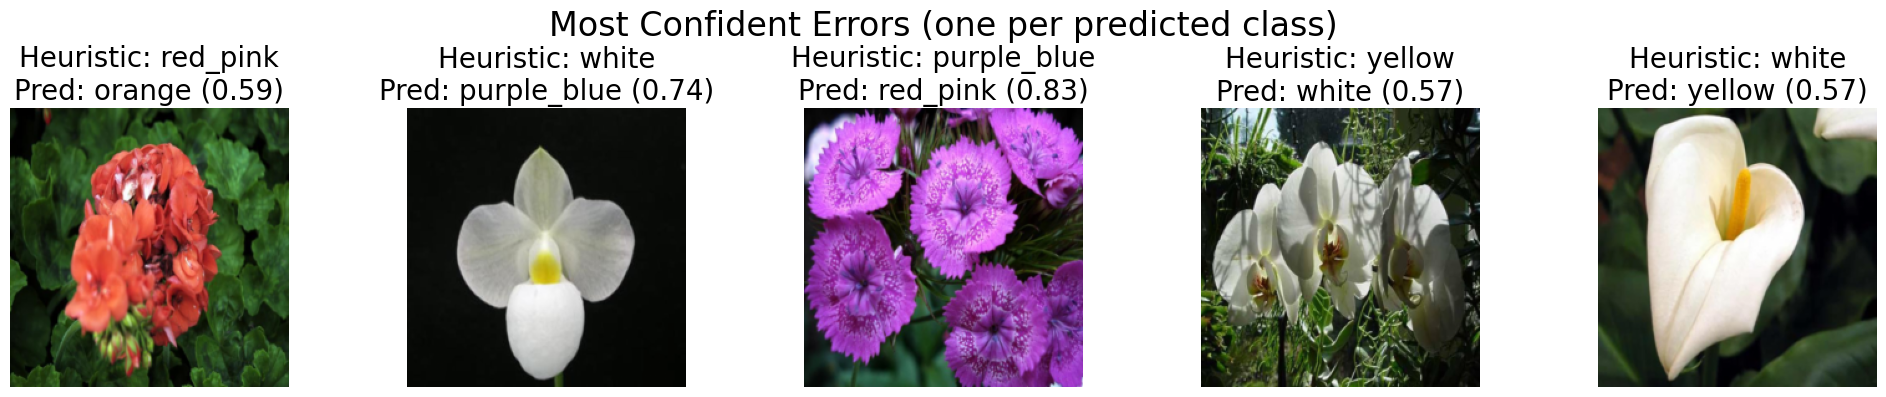

In [18]:
# Pick one randomized example per predicted label, biased toward highest-confidence errors
picked = {}
for pred_name in TARGET_PRED_LABELS:
    candidates = errors_by_pred.get(pred_name, [])
    if len(candidates) == 0:
        picked[pred_name] = None
        continue

    # Sort by confidence descending and sample from the top-N to keep it "high-confidence" but still randomized
    candidates = sorted(candidates, key=lambda t: t[0], reverse=True)
    top_n = min(50, len(candidates))
    picked[pred_name] = random.choice(candidates[:top_n])
    
# Plot grid
fig, axes = plt.subplots(1, len(TARGET_PRED_LABELS), figsize=(4 * len(TARGET_PRED_LABELS), 4))
if len(TARGET_PRED_LABELS) == 1:
    axes = [axes]

for ax, pred_name in zip(axes, TARGET_PRED_LABELS):
    item = picked[pred_name]
    ax.axis("off")

    if item is None:
        ax.set_title(f"Pred: {pred_name}\n(no errors found)", fontsize=20)
        continue

    conf_val, img_norm, true_name, pred_name2 = item
    img_vis = denorm(img_norm)

    ax.imshow(img_vis.permute(1, 2, 0))
    ax.set_title(
        f"Heuristic: {true_name}\nPred: {pred_name2} ({conf_val:.2f})",
        fontsize=20
    )

plt.suptitle("Most Confident Errors (one per predicted class)", fontsize=24)
plt.tight_layout()
plt.show()


### Interpreting Most Confident Errors

Inspection of high-confidence misclassifications reveals that many apparent errors arise not from model failure, but from limitations of the heuristic labeling procedure and from intrinsic ambiguity in flower coloration.

A common pattern involves multi-colored flowers, such as petals that transition from yellow at the center to white at the edges, or flowers with both purple-tinted and yellow-tinted petals. In these cases, the heuristic hue-based labeling may assign a different label than the model, which appears to focus more consistently on the dominant petal coloration. These disagreements highlight cases where the model’s prediction is plausibly more biologically meaningful than the heuristic “ground truth.”

Other high-confidence errors occur at natural color boundaries, including orange versus yellow, orange versus red_pink, and red_pink versus purple_blue. These confusions reflect the continuous nature of pigment composition in flowers rather than discrete categorical errors. In many such examples, either label could reasonably be defended based on lighting conditions, petal heterogeneity, or subjective color interpretation.

## Discussion

An overall accuracy of approximately 75%, strong diagonal dominance in the confusion matrix, and sensible precision/recall patterns are consistent with a model that has learned meaningful color structure while appropriately expressing uncertainty in edge cases. Importantly, high-confidence misclassifications rarely correspond to egregious errors (e.g., yellow predicted as purple_blue), but instead cluster around biologically and visually adjacent categories.

Overall, this evaluation indicates that the classifier performs robustly given noisy, heuristic supervision and that many remaining errors are attributable to labeling ambiguity rather than model misunderstanding.